In [1]:
# Reinforcment Learning with Foirier/Polynomial State Weighted Q Basis for Homogeus Multi Component Maitenance
# By Joseph Wittrock

# Enviroment/Training code adapted from:
# https://pytorch.org/rl/stable/tutorials/torchrl_envs.html
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# The enviroment is composed of n components with m condition states. Each component degrades each step according to its degredation transition matrix. 
# The actions to the enviroment are 0 for do nothing, or 1 for repair.
# Only k components can be repaired at a time, and the repair cost is proportional to the number of components repaired.
# If a component is in a failed state, it will have a failure cost no matter what action is taken. (Though I want to change how this works for multiperiod adaptation)
# The goal is to maximize the reward over a fixed number of steps, reward is negative for repair costs and failure costs.

# The enviroment is written using TorchRL and TensorDict for efficient paralell computation on a cuda enabled GPU.

# The state space is reduced by considering the distrobution of the components in each condition state, rather than the condition state of each component.
# This condenses the state space to m states.

# To generalize the action space we search for an "equitable" policy. i.e. a component in worse condition is always repaired before a component in better condition.
# This reduces the action space to k actions.

# For large values of m, a traditional deep Q network would not generalize well, as there are too many output neurons.
# Instead, we use a basis of continuous valued functions over [0,1], and map the action space to i \mapsto i/k for i in [0,k]. 
# Note when i=0, no components are repaired, and when i=k, all components are repaired, so there are k+1 actions in total.

# The degrees of approximation determine the output nodes for the neural network, then the output is dot producted with the basis functions evaluated at the precalculated action domain points.
# This allows for scale free computation for increasing values of the repair constraint.

In [2]:
from typing import Optional

from matplotlib import pyplot as plt # for plotting
import numpy as np # for cpu based computation
import torch # for efficient (gpu) computation and automatic differentiation
from tqdm import tqdm # for progress bars
from tensordict import TensorDict, TensorDictBase # for handling dictionaries of tensors in a pytorch friendly way, e.g. for batched data
from torch import nn # for neural networks
import torch.optim as optim # for optimizers
import torch.nn.functional as F # for activation functions
from torch.utils.tensorboard import SummaryWriter # for logging to tensorboard


# TorchRL
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec # for defining the shape and type of data [Legacy]
from torchrl.data import Bounded, Composite, Unbounded # for defining the shape and type of data
from torchrl.envs import (
    CatTensors, # Concatenate tensors
    EnvBase, # Tensordict based env
    Transform, # Transform for envs
)
from torchrl.envs.transforms.transforms import _apply_to_composite # for applying a transform to a composite spec
from torchrl.envs.utils import check_env_specs, step_mdp # for checking env specs and stepping through an MDP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # enable cuda if available 
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [3]:
######################
#                    #
#   HYPERPARAMETERS  #
#                    #
######################

# Environment parameters
N_COMPONENTS = 1000 # number of components in each enviroment
MAX_REPAIR_CONSTRAINT = 50 # Maximum number of components that can be repaired in a single step
EPISODE_LENGTH = 128 # number of steps in each episode
STEP_BATCH_SIZE = 128 # number of environments to be executed in paralell
# - Cost parameters
# REPAIR_COST = 10.0 # cost per repair action taken each step
# FAILURE_COST = 20.0 # cost per maximum state (failed state) component each step
REWARD_BLEND = 0.65 # weight for blending orm costs and utility

# Optimization parameters
OPTIMIZATION_BATCH_SIZE = 64 * EPISODE_LENGTH # number of transitions to be used used in each optimization batch
BUFFER_SIZE = 1 * STEP_BATCH_SIZE * EPISODE_LENGTH # number of transitions to be stored in the memory replay buffer
OPTIMIZATION_PASSES = 1 # number of optimization passes to be made in each step
GAMMA = 1 # reward discount factor \in [0, 1]
TAU = 1e-2 # soft target network learning rate. \in [0, 1]
LR = 1e-2 # learning rate for policy network. \in [0, 1]
N_EPISODES = 100
EPOCHS = N_EPISODES * EPISODE_LENGTH  # number of epochs to train the policy network
# - Entropy parameters
ENTROPY_START = 0.5 # initial entropy value for random actions
ENTROPY_END = 0.15  # entropy value for random actions
ENTROPY_DECAY = 1_000  # entropy decay rate 
# - Agent Network parameters
BASIS =   "polynomial" # "fourier" #
N_DEEP_NODES = 32 # number of nodes in the deep network
DEGREE_APPROXIMATION = 3 # basis elements to be generated for action value approximation



In [4]:
###### Generate Other Parameters ######

# evaluate basis functions at every relevant action
# a = k / MAX_REPAIR_CONSTRAINT \in [0, 1] 
# for k \in { 0, 1, 2, ...,  MAX_REPAIR_CONSTRAINT }
basis_switch = { 
    "polynomial": torch.tensor([
        [ (n / MAX_REPAIR_CONSTRAINT )**k for n in range(MAX_REPAIR_CONSTRAINT ) ] 
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    "fourier": torch.tensor([
        [np.cos(1 * np.pi * k * n / MAX_REPAIR_CONSTRAINT) for n in range(MAX_REPAIR_CONSTRAINT )]
        for k in range(DEGREE_APPROXIMATION)
    ], dtype=torch.float32),
    }
basis = basis_switch[ BASIS ]


def get_basis(degree: int, max_repair_constraint: int, basis_type: str = "polynomial") -> torch.Tensor:
    if basis_type == "polynomial":
        return torch.tensor([
            [ (n / max_repair_constraint )**k for n in range(max_repair_constraint ) ] 
            for k in range(degree)
        ], dtype=torch.float32)
    elif basis_type == "fourier":
        return torch.tensor([
            [np.cos(1 * np.pi * k * n / max_repair_constraint) for n in range(max_repair_constraint )]
            for k in range(degree)
        ], dtype=torch.float32)

basis = basis.to(device)
basis.shape

# Degredation Transition Matrix
# Degredation Transition Matrix
transition_matrix_degrade = torch.tensor([
    [0.90, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.05, 0.90, 0.0, 0.0, 0.0, 0.0],
    [0.04, 0.04, 0.8, 0.0, 0.0, 0.0],
    [0.02, 0.03, 0.15, 0.8, 0.0, 0.0],
    [0.0, 0.025, 0.04, 0.1, 0.8, 0.0],
    [0.0, 0.005, 0.01, 0.1, 0.2, 1.0],
], device=device).T 

# Number of discrete condition states per component
N_CONDITION_STATES = transition_matrix_degrade.shape[0]

# Repair Matrix
transition_matrix_repair = torch.zeros((N_CONDITION_STATES, N_CONDITION_STATES), device=device)
transition_matrix_repair[:, 0] = 1.0 # send to the first state

# Pack matrices into a single tensor
transition_matrices = torch.stack([transition_matrix_degrade, transition_matrix_repair])

# Reward function
def make_r_s_a(repair_cost, failure_cost):
    r_s_a = torch.zeros(N_CONDITION_STATES, 2, device=device)
    r_s_a[:, 1] = -repair_cost
    r_s_a[-1, :] = -failure_cost
    return r_s_a

# r_s_a = make_r_s_a(REPAIR_COST, FAILURE_COST)


# Homogeneous Setup
transition_tensor = torch.cat([transition_matrices for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, 2, N_CONDITION_STATES, N_CONDITION_STATES)
# rsa_tensor = torch.cat([r_s_a for _ in range(N_COMPONENTS)]).reshape(N_COMPONENTS, N_CONDITION_STATES, 2)

# Max cost used for normalizing rewards
# max_cost = FAILURE_COST * N_COMPONENTS

# rsa_tensor /= max_cost

In [5]:
# hyperparameter dictionary for accessing hyperparameters in other scripts

hyperparameters = TensorDict(
    N_COMPONENTS=N_COMPONENTS,
    N_CONDITION_STATES=N_CONDITION_STATES,
    MAX_REPAIR_CONSTRAINT=MAX_REPAIR_CONSTRAINT,
    EPISODE_LENGTH=EPISODE_LENGTH,
    STEP_BATCH_SIZE=STEP_BATCH_SIZE,
    # REPAIR_COST=REPAIR_COST,
    # FAILURE_COST=FAILURE_COST,
    REWARD_BLEND=REWARD_BLEND,
    OPTIMIZATION_BATCH_SIZE=OPTIMIZATION_BATCH_SIZE,
    BUFFER_SIZE=BUFFER_SIZE,
    OPTIMIZATION_PASSES=OPTIMIZATION_PASSES,
    GAMMA=GAMMA,
    TAU=TAU,
    LR=LR,
    N_EPISODES=N_EPISODES,
    EPOCHS=EPOCHS,
    ENTROPY_START=ENTROPY_START,
    ENTROPY_END=ENTROPY_END,
    ENTROPY_DECAY=ENTROPY_DECAY,
    BASIS=BASIS,
    BASIS_DOMAIN=basis,
    N_DEEP_NODES=N_DEEP_NODES,
    DEGREE_APPROXIMATION=DEGREE_APPROXIMATION,
)

hyperparameters.to(device)

# hyperparameters

TensorDict(
    fields={
        BASIS: NonTensorData(data=polynomial, batch_size=torch.Size([]), device=cuda:0),
        BASIS_DOMAIN: Tensor(shape=torch.Size([3, 50]), device=cuda:0, dtype=torch.float32, is_shared=True),
        BUFFER_SIZE: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        DEGREE_APPROXIMATION: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_DECAY: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        ENTROPY_END: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        ENTROPY_START: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        EPISODE_LENGTH: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        EPOCHS: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        GAMMA: Tensor(shape=torch.Size([]), device=cuda

In [6]:
from maitenance_util_cost_env import DiscreteMaitenanceEnv, gen_params,  load_dynamics, generate_maitenance_env, reset_maitenance_env

utility = torch.linspace(0, 1, N_COMPONENTS, device=device) 
orm_costs = torch.linspace(0, 1, MAX_REPAIR_CONSTRAINT+1, device=device) 
orm_costs[1:] = (orm_costs[1:] + 0.3) / 1.3 # average the costs for each action

# load data into enviroment global variables

load_dynamics(transition_tensor, orm_costs, utility, hyperparameters)

# generate enviroment based on hyperparameters and transition/reward tensors
env = generate_maitenance_env(device=device)


Using device: cuda


In [7]:
# check_env_specs(env)

In [8]:
from deep_q_target_training import MaitenanceDQBNTrainer

# dqt = MaitenanceDQBNTrainer(hyperparameters, env,)

# dqt.create_models()

# dqt.train()
 
# dqt.benchmark_UC()

test_LR = torch.linspace(0.02, 0.0001, 25, device=device)
test_degree_approximation = torch.tensor([ 2, 3, 4, 5, 6, 7, 8 ], device=device)
test_DEEP_NODES = torch.tensor([16,24,32,48,64, 128], device=device)

Using device: cuda


In [9]:


score_cache_linear = torch.zeros_like(test_LR)

pbar = tqdm(total=len(test_LR))

for i, LR in enumerate(test_LR):
    pbar.update(1)
    hyperparameters["LR"] = LR
    dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
    dqt.create_linear_models()
    dqt.train(verbose=False)
    score = dqt.benchmark()
    score_cache_linear[i] = score
    # print(f"Score: {score} at LR: {LR}")

pbar.close()

torch.max(score_cache_linear)


score_cache_linear = score_cache_linear.cpu().numpy()
score_cache_linear.tofile("score_cache_linear.txt")

  0%|          | 0/25 [00:00<?, ?it/s]/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/torchrl/data/tensor_specs.py:5464: DeprecationWarning: The BoundedTensorSpec has been deprecated and will be removed in v0.7. Please use Bounded instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
score_cache_linear_AK = torch.zeros((len(test_LR),len(test_degree_approximation)), device=device)

pbar = tqdm(total=len(test_LR) * len(test_degree_approximation))

for i, LR in enumerate(test_LR):
    for j, DEGREE_APPROXIMATION in enumerate(test_degree_approximation):
        pbar.update(1)
        hyperparameters["DEGREE_APPROXIMATION"] = DEGREE_APPROXIMATION
        hyperparameters["BASIS_DOMAIN"] = get_basis(DEGREE_APPROXIMATION, MAX_REPAIR_CONSTRAINT, BASIS)
        hyperparameters["LR"] = LR
        dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
        dqt.create_linear_AK_models()
        dqt.train(verbose=False)
        score = dqt.benchmark(n_episodes=25)
        score_cache_linear_AK[i, j] = score
        # print(f"Score: {score} at LR: {LR}")

pbar.close()
torch.max(score_cache_linear_AK)

score_cache_linear_AK = score_cache_linear_AK.cpu().numpy()
score_cache_linear_AK.tofile("score_cache_linear_AK.txt")

  7%|▋         | 13/175 [20:09<6:08:35, 136.52s/it]

In [ ]:
score_cache_linear_AK_forier = torch.zeros((len(test_LR),len(test_degree_approximation)), device=device)

pbar = tqdm(total=len(test_LR) * len(test_degree_approximation))

for i, LR in enumerate(test_LR):
    for j, DEGREE_APPROXIMATION in enumerate(test_degree_approximation):
        
        hyperparameters["DEGREE_APPROXIMATION"] = DEGREE_APPROXIMATION
        hyperparameters["BASIS_DOMAIN"] = get_basis(DEGREE_APPROXIMATION, MAX_REPAIR_CONSTRAINT, "fourier")
        hyperparameters["LR"] = LR
        dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
        dqt.create_linear_AK_models()
        dqt.train(verbose=False)
        score = dqt.benchmark(n_episodes=25)
        score_cache_linear_AK_forier[i, j] = score
        # print(f"Score: {score} at LR: {LR}")
        pbar.update(1)

pbar.close()
torch.max(score_cache_linear_AK_forier)

score_cache_linear_AK = score_cache_linear_AK_forier.cpu().numpy()
score_cache_linear_AK.tofile("score_cache_linear_AK_forier.txt")

100%|██████████| 175/175 [2:53:08<00:00, 59.36s/it]  


In [ ]:

score_cache_DQ = torch.zeros((len(test_LR),len(test_DEEP_NODES)), device=device)

pbar = tqdm(total=len(test_LR)*len(test_DEEP_NODES))

for i, LR in enumerate(test_LR):
    for j, N_DEEP_NODES in enumerate(test_DEEP_NODES):
        pbar.update(1)
        hyperparameters["LR"] = LR
        hyperparameters["N_DEEP_NODES"] = N_DEEP_NODES
        dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
        dqt.create_models()
        dqt.train(verbose=False)
        score = dqt.benchmark(n_episodes=25)
        score_cache_DQ[i,j] = score
    # print(f"Score: {score} at LR: {LR}")

pbar.close()

torch.max(score_cache_DQ)

score_cache_DQ = score_cache_DQ.cpu().numpy()
score_cache_DQ.tofile("score_cache_DQ.txt")

100%|██████████| 150/150 [2:30:17<00:00, 60.12s/it] 


In [ ]:
score_cache_DQAK = torch.zeros((len(test_LR),len(test_degree_approximation), len(test_DEEP_NODES)), device=device)

pbar = tqdm(total=len(test_LR)*len(test_DEEP_NODES)* len(test_degree_approximation))

for i, LR in enumerate(test_LR):
    for j, DEGREE_APPROXIMATION in enumerate(test_degree_approximation):
        for k, N_DEEP_NODES in enumerate(test_DEEP_NODES):
            pbar.update(1)
            hyperparameters["LR"] = LR
            hyperparameters["DEGREE_APPROXIMATION"] = DEGREE_APPROXIMATION
            hyperparameters["BASIS_DOMAIN"] = get_basis(DEGREE_APPROXIMATION, MAX_REPAIR_CONSTRAINT, basis_type="polynomial")
            hyperparameters["N_DEEP_NODES"] = N_DEEP_NODES
            dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
            dqt.create_AK_models()
            dqt.train(verbose=False)
            score = dqt.benchmark(n_episodes=25)
            score_cache_DQAK[i,j,k] = score
    # print(f"Score: {score} at LR: {LR}")

pbar.close()

torch.max(score_cache_DQAK)

score_cache_DQAK = score_cache_DQAK.cpu().numpy()
score_cache_DQAK.tofile("score_cache_DQAK.txt")

 14%|█▍        | 149/1050 [2:41:07<16:33:02, 66.13s/it]

KeyboardInterrupt: 

In [ ]:
score_cache_DQAK_forier = torch.zeros((len(test_LR),len(test_degree_approximation), len(test_DEEP_NODES)), device=device)

pbar = tqdm(total=len(test_LR)*len(test_DEEP_NODES)* len(test_degree_approximation))

for i, LR in enumerate(test_LR):
    for j, DEGREE_APPROXIMATION in enumerate(test_degree_approximation):
        for k, N_DEEP_NODES in enumerate(test_DEEP_NODES):
            pbar.update(1)
            hyperparameters["LR"] = LR
            hyperparameters["DEGREE_APPROXIMATION"] = DEGREE_APPROXIMATION
            hyperparameters["BASIS_DOMAIN"] = get_basis(DEGREE_APPROXIMATION, MAX_REPAIR_CONSTRAINT, basis_type="fourier")
            hyperparameters["N_DEEP_NODES"] = N_DEEP_NODES
            dqt = MaitenanceDQBNTrainer(hyperparameters, env,)
            dqt.create_AK_models()
            dqt.train(verbose=False)
            score = dqt.benchmark(n_episodes=25)
            score_cache_DQAK_forier[i,j,k] = score
    # print(f"Score: {score} at LR: {LR}")

pbar.close()



  0%|          | 0/1050 [00:00<?, ?it/s]/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/torchrl/data/tensor_specs.py:5464: DeprecationWarning: The BoundedTensorSpec has been deprecated and will be removed in v0.7. Please use Bounded instead.
  warnings.warn(
100%|██████████| 1050/1050 [18:32:25<00:00, 63.57s/it]  


In [ ]:
# save scores to text files



score_cache_DQAK_forier = score_cache_DQAK_forier.cpu().numpy()
score_cache_DQAK_forier.tofile("score_cache_DQAK_forier.txt")



In [ ]:
# send all scores to cpu for plotting


np.max(score_cache_DQAK_forier)


0.6563661

/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


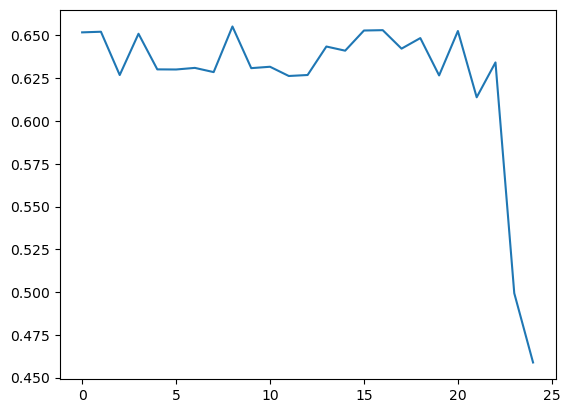

In [ ]:
plt.plot(score_cache_linear)

Text(0.5, 1.0, 'Linear AK Model Hyper Parameter Search')

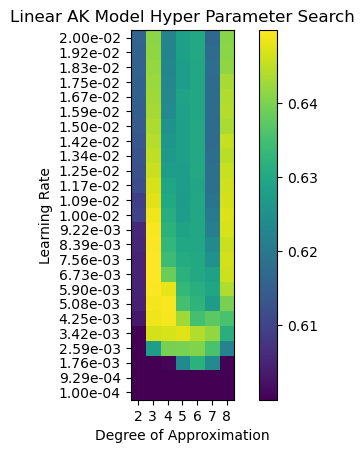

In [ ]:
plt.imshow(score_cache_linear_AK)
plt.colorbar()
y_ticks = test_LR.cpu().numpy()
# round 
y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

plt.xticks(range(len(test_degree_approximation)), test_degree_approximation.cpu().numpy())
plt.yticks(range(len(test_LR)), y_ticks)
plt.xlabel("Degree of Approximation")
plt.ylabel("Learning Rate")
plt.title("Linear AK Model Hyper Parameter Search")

Text(0, 0.5, 'Learning Rate')

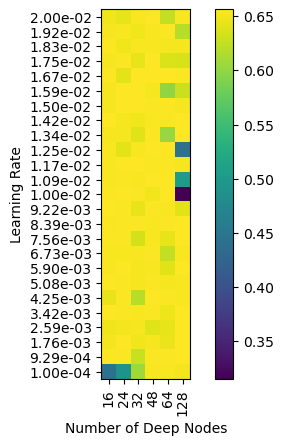

In [ ]:
plt.imshow(score_cache_DQ)
plt.colorbar()
y_ticks = test_LR.cpu().numpy()
# round 
y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

plt.xticks(range(len(test_DEEP_NODES)), test_DEEP_NODES.cpu().numpy(), rotation=90)
plt.yticks(range(len(test_LR)), y_ticks)
plt.xlabel("Number of Deep Nodes")
plt.ylabel("Learning Rate")


Degree: 2
0.65290976


/home/nemo/anaconda3/envs/torch/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


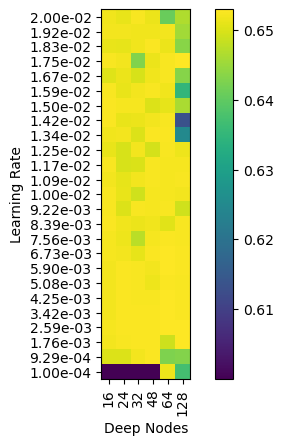

Degree: 3
0.6563211


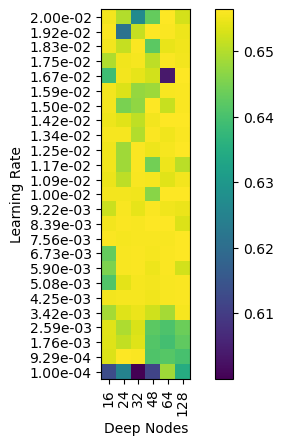

Degree: 4
0.655958


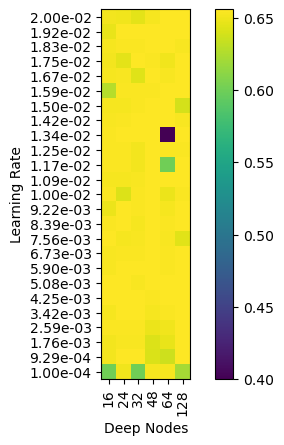

Degree: 5
0.6563661


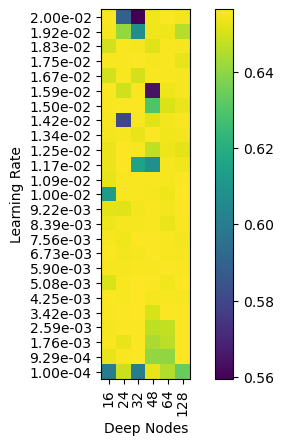

Degree: 6
0.6561967


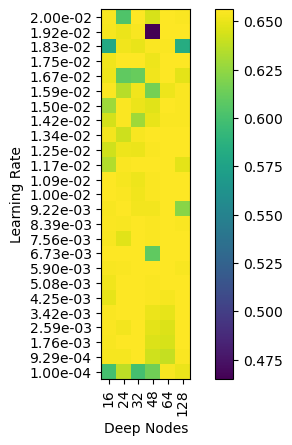

Degree: 7
0.6561682


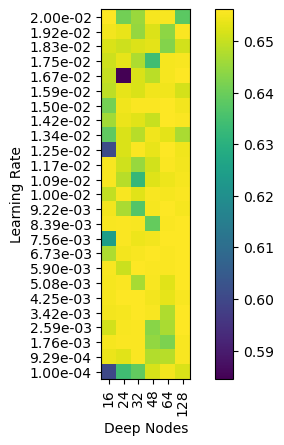

Degree: 8
0.65626967


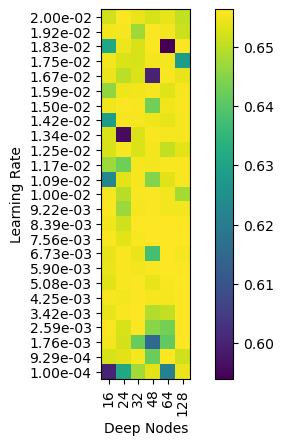

In [ ]:
min_score = np.min(score_cache_DQAK_forier)
max_score = np.max(score_cache_DQAK_forier)

for i, degree in enumerate(test_degree_approximation):
	print(f"Degree: {degree}")
	# print max score
	print(np.max(score_cache_DQAK_forier[:,i,:]))
	plt.imshow(score_cache_DQAK_forier[:,i,:],)
	plt.xlabel("Deep Nodes")
	plt.ylabel("Learning Rate")

	y_ticks = test_LR.cpu().numpy()
	# round 
	y_ticks = [ "{:.2e}".format(y) for y in y_ticks ]

	plt.xticks(range(len(test_DEEP_NODES)), test_DEEP_NODES.cpu().numpy(), rotation=90)
	plt.yticks(range(len(test_LR)), y_ticks)

	plt.colorbar()
	plt.show()

In [ ]:
# argmax of scores
linear_i_lr = np.unravel_index(np.argmax(score_cache_linear), score_cache_linear.shape)
linear_best_lr = test_LR[linear_i_lr]
linear_best_score = score_cache_linear[linear_i_lr]

linear_AK_i_lr, linear_AK_i_degree = np.unravel_index(np.argmax(score_cache_linear_AK), score_cache_linear_AK.shape)
linear_AK_best_lr = test_LR[linear_AK_i_lr]
linear_AK_best_degree = test_degree_approximation[linear_AK_i_degree]
linear_AK_best_score = score_cache_linear_AK[linear_AK_i_lr, linear_AK_i_degree]

DQ_i_lr, DQ_i_deep = np.unravel_index(np.argmax(score_cache_DQ), score_cache_DQ.shape)
DQ_best_lr = test_LR[DQ_i_lr]
DQ_best_deep = test_DEEP_NODES[DQ_i_deep]
DQ_best_score = score_cache_DQ[DQ_i_lr, DQ_i_deep]

DQAK_i_lr, DQAK_i_degree, DQAK_i_deep = np.unravel_index(np.argmax(score_cache_DQAK), score_cache_DQAK.shape)
DQAK_best_lr = test_LR[DQAK_i_lr]
DQAK_best_degree = test_degree_approximation[DQAK_i_degree]
DQAK_best_deep = test_DEEP_NODES[DQAK_i_deep]
DQAK_best_score = score_cache_DQAK[DQAK_i_lr, DQAK_i_degree, DQAK_i_deep]

In [ ]:
print(f"Linear Best Score: \t{linear_best_score: .4f} \t at LR: {linear_best_lr: .3e}")
print(f"Linear AK Best Score: \t{linear_AK_best_score: .4f} \t at LR: {linear_AK_best_lr: .3e} and Degree: {linear_AK_best_degree}")
print(f"DQ Best Score: \t\t{DQ_best_score: .4f} \t at LR: {DQ_best_lr: .3e} and Deep Nodes: {DQ_best_deep}")
print(f"DQ AK Best Score: \t{DQAK_best_score: .4f} \t at LR: {DQAK_best_lr: .3e} and Degree: {DQAK_best_degree} and Deep Nodes: {DQAK_best_deep}")


# latex table
print(f"Linear & {linear_best_score: .4f} & {linear_best_lr: .3e} \\\\")
print(f"Linear AK & {linear_AK_best_score: .4f} & {linear_AK_best_lr: .3e} & {linear_AK_best_degree} \\\\")
print(f"DQ & {DQ_best_score: .4f} & {DQ_best_lr: .3e} & {DQ_best_deep} \\\\")
print(f"DQ AK & {DQAK_best_score: .4f} & {DQAK_best_lr: .3e} & {DQAK_best_degree} & {DQAK_best_deep} \\\\")



Linear Best Score: 	 0.6552 	 at LR:  1.337e-02
Linear AK Best Score: 	 0.6498 	 at LR:  6.733e-03 and Degree: 3
DQ Best Score: 		 0.6561 	 at LR:  1.171e-02 and Deep Nodes: 24
DQ AK Best Score: 	 0.6562 	 at LR:  7.562e-03 and Degree: 3 and Deep Nodes: 48
Linear &  0.6552 &  1.337e-02 \\
Linear AK &  0.6498 &  6.733e-03 & 3 \\
DQ &  0.6561 &  1.171e-02 & 24 \\
DQ AK &  0.6562 &  7.562e-03 & 3 & 48 \\


In [ ]:
print(f"DQ AK Forier Best Score: \t{np.max(score_cache_DQAK_forier): .4f} \t at LR: {test_LR[np.argmax(score_cache_DQAK_forier)]: .3e} and Degree: {test_degree_approximation[np.argmax(score_cache_DQAK_forier) // len(test_DEEP_NODES)]} and Deep Nodes: {test_DEEP_NODES[np.argmax(score_cache_DQAK_forier) % len(test_DEEP_NODES)]}")

IndexError: index 779 is out of bounds for dimension 0 with size 25

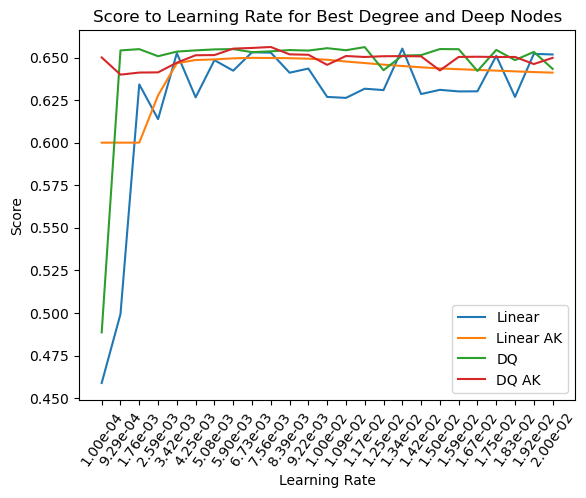

In [ ]:
# Plot score to LR fixing other best variables

plt.plot(test_LR.cpu().numpy(), score_cache_linear[:])
plt.plot(test_LR.cpu().numpy(), score_cache_linear_AK[:,linear_AK_i_degree])
plt.plot(test_LR.cpu().numpy(), score_cache_DQ[:,DQ_i_deep])
plt.plot(test_LR.cpu().numpy(), score_cache_DQAK[:,DQAK_i_degree, DQAK_i_deep])
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.xticks(test_LR.cpu().numpy(), [ "{:.2e}".format(x) for x in test_LR.cpu().numpy() ], rotation=55)
plt.legend(["Linear", "Linear AK", "DQ", "DQ AK"])
plt.title("Score to Learning Rate for Best Degree and Deep Nodes")
plt.show()

